# Python y testeo estadístico: El caso de Ventanas 
### Abstract
Utilizando el lenguaje de programación Python, tras unificar los
registros anuales de defunciones en Chile 1998-2016
(~1.7M), analizamos los diagnósticos primarios en
defunciones de menores hasta 16 años, comparando la zona crítica bajo la
contaminación del complejo industrial Quintero-Ventanas, contra el resto
de Chile como control. Encontramos incidencias de malformaciones
congénitas, deformidades y anomalías cromosómicas (CIE-10: Q00-Q99),
3.04 a 3.75 desviaciones estándar sobre el resto del país, con P-values
de 0.0001 a 0.00002 en un millón de simulaciones, estimando un impacto
de entre 29.73 a 37.8 muertes de menores en la zona crítica por sobre la
norma nacional. La metodología podría ser escalada a todo el país para
detectar focos de contaminación desconocidos.


## Una comparativa entre la zona crítica y el resto de Chile 
### Introducción 
Mediante programación en _Python_ fue posible estandarizar los registros de defunciones oficiales, que tienen una serie de variaciones año a año. Una vez construida un [registro unificado de defunciones en Chile, entre el año 1998 y 2016](https://github.com/verasativa/defunciones-decoder), surge la pregunta general: ¿Se podrán observar en éste, rasgos distintos en una zona crítica al resto de Chile? Utilizando el mismo lenguaje de programación testearemos esa hipótesis.

Un aporte clave es la metodología, y por esta razón se disponibiliza todo el [código fuente](readme.ipynb), posibilitando la implementación y extensión de ésta en otros problemas, territorios o datasets. 

### Antecedentes
El impacto ambiental y sobre la salud humana del complejo industrial
Quintero-Ventanas ha sido ampliamente documentado al punto de que recientemente el Colegio Medico chileno dedicó un número completo de su revista de salud pública [Cuadernos Médico Sociales](https://view.joomag.com/cuadernos-m%C3%A9dicos-sociales-2019-vol-59-n1/0276621001558620771?short) al problema.

El reciente informe [The Lancet Commission on Pollution and Health](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(17)32345-0/fulltext) señala que la polución del aire puede ser vinculada al aumento de nacimientos prematuros y con bajo peso. Y que algunos estudios hanmostrado asociación entre polución ambiental del aire y aumento del riesgo de síndrome de muerte súbita del lactante.

### Comparación de diagnósticos primarios
Para buscar una respuesta a la asociación entre contaminación ambiental y enfermedades de la gestación, es posible usar con todas sus limitaciones los registros de defunciones oficiales del país. Una forma de avanzar por sobre esas restricciones, es hacer uso de [la integración jerárquica de los códigos de diagnóstico CIE-10](https://github.com/verasativa/CIE-10) en el dataset, una comparación de éstos, se presenta como la opción más evidente y atractiva, mediante un trabajo de programación en Phyton. Este trabajo desarrolla una metodología de programación orientada al objeto de estudio y pone a Phyton como una alternativa para su uso en salud pública.

### Limitaciones de los datos
Para entender que podemos investigar desde estos datos, debemos reconocer sus limitaciones. Dado que este dataset solo incluye las defunciones y no contiene información sobre la población general, no es posible hacer un análisis respecto a tasas de ocurrencia sin tener que usar datoscomo censos. La ruralidad de la zona, conjugada con la migración campo-ciudad, produce un movimiento poblacional que en ese período aumenta la incertidumbre de las cifras. Tampoco podemos hacer un análisis sobre la distribución etaria de la mortalidad, ni la
distribución de diagnósticos primarios en la población general, sin normalizar primero con datos adicionales.

### Pregunta de investigación
Con esas limitaciones en mente, podemos plantear una pregunta sencilla, pero contestable:

__¿Cómo se comparan los diagnósticos primarios de defunciones, en la zona de interés con respecto al resto del país, en menores hasta 16 años?__

### Proceso exploratorio: definiendo la "zona de interés"
Inicialmente, se exploró como zona de interés solamente las comunas de Quintero y Puchuncaví, puesto que son colindantes (Quintero) o el lugar mismo del foco industrial de contaminación.

In [2]:
# Load defunciones
%matplotlib inline
import pandas as pd
import json, os

# Locals v/s floydhub
if 'TERM_PROGRAM' in os.environ:
    input_path = '../datasets/defunciones-decoded/'
else:
    input_path = '/floyd/input/defunciones/'

# Dtypes
# Load dtypes from json
with open(input_path + 'dtypes.json') as json_data:
    read_dtypes = json.load(json_data)
date_fields = []

# Capture datetime fields
for col in read_dtypes:
    if read_dtypes[col] == 'datetime64[ns]':
        date_fields.append(col)
        
# Remove datetime fields
for field in date_fields:
    del read_dtypes[field]
    
defunciones = pd.read_csv(
    input_path + 'defunciones-deis-1998-2016-parsed-1M.csv',
    dtype=read_dtypes,
    parse_dates=date_fields,
    index_col=False
)

# Load cie-10 codes
cie10 = pd.read_csv(input_path + 'cie-10.csv').set_index('code')
def describe_cie10_index(Series):
    tmp = pd.Series()
    for row in Series.items():
        tmp[cie10.loc[row[0]].description + '\n' + row[0]] = row[1]
    return tmp

In [3]:
def describe_cie10_index(Series):
    tmp = pd.Series()
    for row in Series.items():
        tmp[cie10.loc[row[0]].description + '\n' + row[0]] = row[1]
    return tmp

Zona de interés: Quintero, Puchuncaví
Total defunciones en el grupo de interés: 119
Total defunciones en los 10 principales diagnósticos primarios del grupo de interés: 118
Fracción del total: 0.992


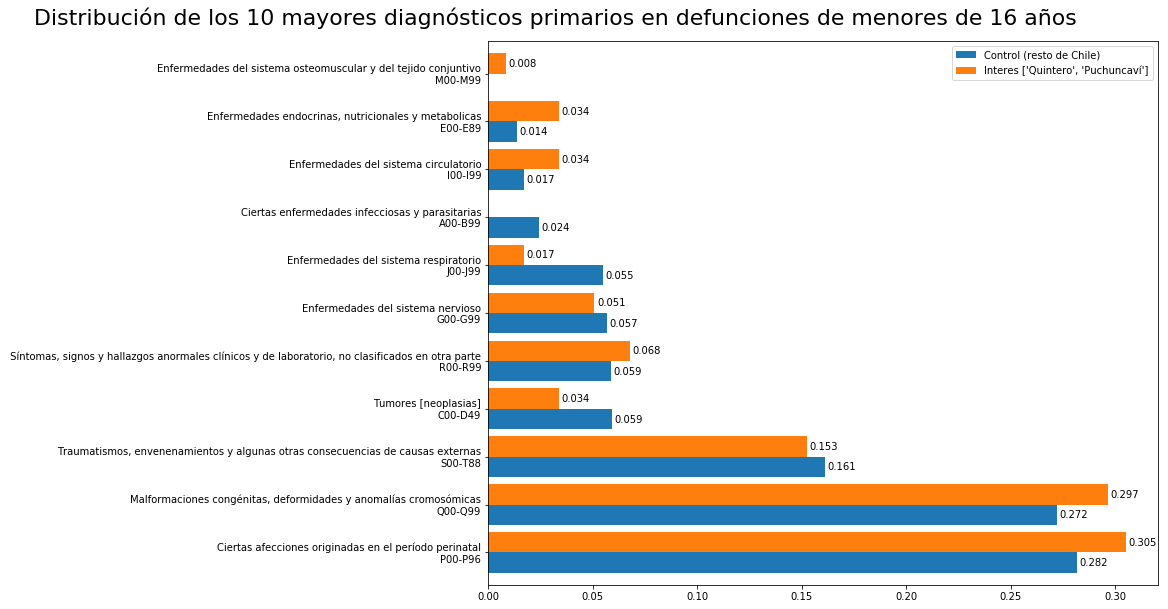

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from transliterate import translit

# Definimos función para uso reiterado
def compare_primary_diagnosis(poblacion, comunas_interes, top_n = 10, footer = False):
    # Creamos grupos
    defunciones_test = poblacion.query('comune in @comunas_interes') # Menores en zona de interes
    defunciones_control = poblacion.query('comune not in @comunas_interes') # Menores resto de Chile (control)
    
    # Imprimimos información general
    print('Zona de interés: {}'.format(', '.join(comunas_interes)))
    print('Total defunciones en el grupo de interés: {}'.format(defunciones_test.shape[0]))    
    print('Total defunciones en los {} principales diagnósticos primarios del grupo de interés: {}'.format(
        top_n,
        defunciones_test.primary_code_0.value_counts()[:top_n].sum()
    ))
    print('Fracción del total: {0:.3f}'.format(defunciones_test.primary_code_0.value_counts()[:top_n].sum()/defunciones_test.shape[0]))
    
    # Ploteo
    # Los x diágnosticos primarios mayores en control
    incidencias_control = pd.DataFrame(describe_cie10_index(defunciones_control.primary_code_0.value_counts()[:top_n]), columns=['Control'])
    # Los x diágnosticos primarios mayores en interés
    incidencias_test = pd.DataFrame(describe_cie10_index(defunciones_test.primary_code_0.value_counts()[:top_n]), columns=['Interés'])
    # Concatenamos
    comparativa = pd.concat([incidencias_control, incidencias_test], axis=1, sort=False)
    # A fracción
    comparativa['Control (resto de Chile)'] = comparativa.Control / comparativa.Control.sum()
    comparativa['Interes {}'.format(comunas_interes)] = comparativa.Interés / comparativa.Interés.sum()
    del comparativa['Control']
    del comparativa['Interés']
    ax = comparativa.plot(kind='barh',
                          figsize=(12,10),
                          width=.85)
    ax.set_title('Distribución de los {} mayores diagnósticos primarios en defunciones de menores de 16 años'.format(top_n), size=22, y=1.02, x=.1)
    for p in ax.patches:
        if p.get_width() != 0:
            ax.annotate(np.round(p.get_width(),decimals=3), 
                        (p.get_width()+.008, p.get_y()),
                        ha='center',
                        va='center',
                        xytext=(0, 10),
                        textcoords='offset points')
    if footer:
        pass
        # footer moved to LaTeX
        #plt.annotate(footer, (0,0), (0, -1.5), fontsize=14)
    comunas = '-'.join(comunas_interes).replace(' ', '')
    comunas = translit(comunas, reversed=True) # Eliminamos tildes
    file_name = '{}-diagnosticos-({}).png'.format(top_n, comunas)
    plt.savefig('assets/' + file_name, bbox_inches='tight')
    plt.show()
    plt.close()
    
# Seleccionamos menores
poblacion = defunciones.query('(age_type == "años" and age_amount <= 16) or (age_type in ["meses", "días", "horas"])') #.apply(join_codes, axis=1)
comunas_interes = ["Quintero", "Puchuncaví"]
compare_primary_diagnosis(poblacion, comunas_interes, footer = 'Figura 1')

Sin embargo, no se econtró algo claro ya que podemos observar en la figura 1 que hay dos diagnósticos primarios que presentan incidencias superiores a la nacional. Con la intención de buscar una tendencia más clara y validable (tamaño de la muestra), exploramos la incidencia de estos dos diagnósticos primarios en todas las comunas de la Quinta Región.

In [8]:
#poblacion
diagnosticos_interes = ["P00-P96", "Q00-Q99"]
tablas = {}
# Creamos grupos
defunciones_region = poblacion.query('home_region == "Valparaíso"') # Menores en zona de interes
for diagnostico in diagnosticos_interes:
    ddf = pd.DataFrame()
    for comuna in defunciones_region.comune.unique():
        #display(comuna)
        incidencia_otros = poblacion.query('comune != @comuna and primary_code_0 == @diagnostico').shape[0]
        total_otros = poblacion.query('comune != @comuna').shape[0]
        taza_otros = incidencia_otros / total_otros
        
        incidencia_comuna = poblacion.query('comune == @comuna and primary_code_0 == @diagnostico').shape[0]
        total_comuna = poblacion.query('comune == @comuna').shape[0]
        taza_comuna = incidencia_comuna / total_comuna
        
        fila = {
            'Comuna': comuna,
            'Incidencia otros': incidencia_otros,
            'Total otros': total_otros,
            'Taza otros': taza_otros,
            'Incidencia comuna': incidencia_comuna,
            'Total comuna': total_comuna,
            'Taza comuna': taza_comuna,
        }
        ddf = ddf.append(fila, ignore_index=True)
    print('{} ({})'.format(cie10.loc[diagnostico].description, diagnostico))
    display(ddf.sort_values('Taza comuna', ascending=False)[:12].reset_index(drop=True))
    # Guardamos resultados
    tablas[diagnostico] = ddf.sort_values('Taza comuna', ascending=False)[:12].reset_index(drop=True)

Ciertas afecciones originadas en el período perinatal (P00-P96)


,Comuna,Incidencia comuna,Incidencia otros,Taza comuna,Taza otros,Total comuna,Total otros
0,La Cruz,26.0,15957.0,0.509804,0.274836,51.0,58060.0
1,Rinconada,15.0,15968.0,0.468750,0.274936,32.0,58079.0
2,San Felipe,109.0,15874.0,0.374570,0.274542,291.0,57820.0
3,Olmué,17.0,15966.0,0.369565,0.274968,46.0,58065.0
4,El Tabo,7.0,15976.0,0.368421,0.275012,19.0,58092.0
5,San Esteban,15.0,15968.0,0.357143,0.274983,42.0,58069.0
6,Cartagena,18.0,15965.0,0.339623,0.274984,53.0,58058.0
7,Llaillay,28.0,15955.0,0.337349,0.274953,83.0,58028.0
8,Calle Larga,13.0,15970.0,0.333333,0.275003,39.0,58072.0
9,Algarrobo,11.0,15972.0,0.323529,0.275014,34.0,58077.0


Malformaciones congénitas, deformidades y anomalías cromosómicas (Q00-Q99)


,Comuna,Incidencia comuna,Incidencia otros,Taza comuna,Taza otros,Total comuna,Total otros
0,Puchuncaví,20.0,15428.0,0.434783,0.265702,46.0,58065.0
1,Zapallar,6.0,15442.0,0.428571,0.265797,14.0,58097.0
2,Papudo,3.0,15445.0,0.375000,0.265821,8.0,58103.0
3,La Ligua,37.0,15411.0,0.370000,0.265657,100.0,58011.0
4,Concón,30.0,15418.0,0.352941,0.265708,85.0,58026.0
5,Nogales,20.0,15428.0,0.333333,0.265766,60.0,58051.0
6,Cabildo,20.0,15428.0,0.333333,0.265766,60.0,58051.0
7,Putaendo,19.0,15429.0,0.322034,0.265779,59.0,58052.0
8,El Tabo,6.0,15442.0,0.315789,0.265820,19.0,58092.0
9,Quillota,78.0,15370.0,0.308300,0.265650,253.0,57858.0


In [15]:
# Exportado de tablas a markdown (para otros formatos)
from tabulate import tabulate

for codigo_diagnostico in list(tablas):
    file_path = 'assets/{}.md'.format(codigo_diagnostico)
    header = list(tablas[codigo_diagnostico].columns)
    header.insert(0, '#') # Titulo de columna numeral
    with open(file_path, mode='w') as f:
        f.write('### {} ({})\n\n'.format(cie10.loc[codigo_diagnostico].description, codigo_diagnostico))
        f.write(tabulate(tablas[codigo_diagnostico], headers=header, tablefmt='github'))

Al observar las tablas de incidencia, podemos notar que el diagnóstico primario _Ciertas afecciones originadas en el período perinatal_, está dominado por otras comunas, no primariamente las de la zona de interés. Y por otra parte, el diagnóstico primario de _Malformaciones congénitas, deformidades y anomalías cromosómicas_ domina en comunas colindantes al centro industrial.

Ante esto, decidimos graficar la incidencia de interés en el mapa.

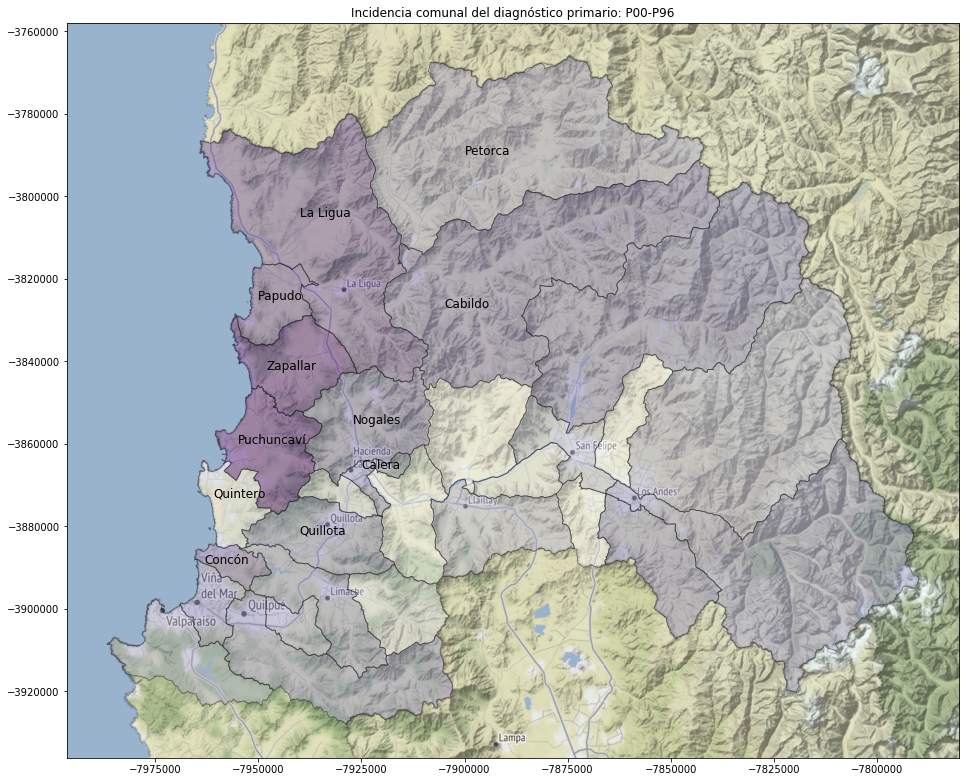

In [11]:
%matplotlib inline

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import sys

comunas_mapa = ['Panquehue', 'Los Andes', 'Rinconada',
       'San Esteban', 'Cabildo', 'La Ligua', 'Papudo', 'Petorca',
       'Zapallar', 'Hijuelas', 'La Cruz', 'Nogales', 'Quillota', 'Catemu',
       'Llaillay', 'Calera', 'Putaendo', 'San Felipe', 'Santa María',
       'Concón', 'Puchuncaví', 'Quintero', 'Valparaíso', 'Viña del Mar',
       'Calle Larga', 'Olmué', 'Quilpué', 'Villa Alemana', 'Limache']
diagnostico = 'Q00-Q99'
file_name = 'assets/mapa.png'
title = "Incidencia comunal del diagnóstico primario: P00-P96"

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
def geo_diagnoses(comunas_mapa):
    return True

# Calcular la incidencia por comuna
# acumulador
incidencia_comunas = pd.DataFrame()
for comuna in comunas_mapa:
    #display(comuna)
    incidencia_otros = poblacion.query('comune != @comuna and primary_code_0 == @diagnostico').shape[0]
    total_otros = poblacion.query('comune != @comuna').shape[0]
    taza_otros = incidencia_otros / total_otros

    incidencia_comuna = poblacion.query('comune == @comuna and primary_code_0 == @diagnostico').shape[0]
    total_comuna = poblacion.query('comune == @comuna').shape[0]
    taza_comuna = incidencia_comuna / total_comuna

    fila = {
        'Comuna': comuna,
        'Taza comuna': taza_comuna,
        'Taza otros': taza_otros,
        'Incidencia comuna': incidencia_comuna,
        'Total comuna': total_comuna,
        'Incidencia otros': incidencia_otros,
        'Total otros': total_otros,
    }
    incidencia_comunas = incidencia_comunas.append(fila, ignore_index=True)
incidencia_comunas = incidencia_comunas.astype({'Incidencia otros': int, 'Total otros': int, 'Incidencia comuna': int, 'Total comuna': int})

# Para que coincida con geodataframe de comunas de Chile
incidencia_comunas['NOM_COM'] = incidencia_comunas.Comuna
# Cargamos vectores de comunas
geo_comunas = gpd.read_file('../datasets/division_comunal/', crs={'init': 'epsg:5361'})
del geo_comunas['SHAPE_Le_1']
geo_comunas = geo_comunas.query('NOM_COM in @comunas_mapa')
geo_incidencia = geo_comunas.merge(incidencia_comunas, how='left', on='NOM_COM')
geo_incidencia = geo_incidencia.to_crs({'init': 'epsg:3857'})
ax = geo_incidencia.plot(column='Taza comuna', figsize=(16,20), alpha=0.4, edgecolor='k', cmap='Purples')
# moved to LaTeX
#ax.annotate("Figura 2", (0,0), xycoords='axes fraction', xytext=(.5, -.05), textcoords='axes fraction', fontsize=16)
add_basemap(ax, zoom=10)
plt.title(title)

comunas_en_mapa = {
    'La Ligua': (-7940000, -3805000),
    'Papudo': (-7950000, -3825000),
    'Zapallar': (-7948000, -3842000),
    'Puchuncaví': (-7955000, -3860000),
    'Quintero': (-7961000,-3873000),
    'Concón': (-7963000,-3889000),
    'Petorca': (-7900000, -3790000),
    'Cabildo': (-7905000, -3827000),
    'Nogales': (-7927000, -3855000),
    'Calera': (-7925000, -3866000),
    'Quillota': (-7940000, -3882000),
}
for comuna, coordenadas in comunas_en_mapa.items():
    ax.annotate(comuna, coordenadas, xytext=coordenadas, fontsize=12)
    
plt.savefig(file_name, bbox_inches='tight')
plt.show()
plt.close()

# Data frame
#print(title)
#incidencia_comunas_friendly = incidencia_comunas.sort_values('Taza comuna', ascending=False).reset_index(drop=True).drop(columns='NOM_COM').reindex(fila.keys(), axis=1)
#display(incidencia_comunas_friendly)

### Se observa una distribución no-radial: ¿Cómo se explica?

En la figura 2 se puede apreciar que las comunas más afectadas parecen ser las directamente al norte (Puchuncaví, Zapallar, Papudo y La Ligua), al este (Nogales, La Calera y Quillota) e incluso directamente al sur (Concón) del complejo industrial. 

Al observar esta distribución no radial, la investigación parecía no tener sentido y se estancó durante un tiempo. Se sospechaba de un patrón de vientos. Para seguir avanzando, fue necesario que se nos refiriera a la investigación de Patricio Cornejo, Juan López y Sergio Romano 1983, donde se creó un mapa que indica la dispersión de contaminación desde el complejo industrial Quintero-Ventanas. 

Al sobreponer ese mapa sobre nuestras incidencias (Figura 3), observamos una coincidencia interesante, que nos llevó a continuar. 

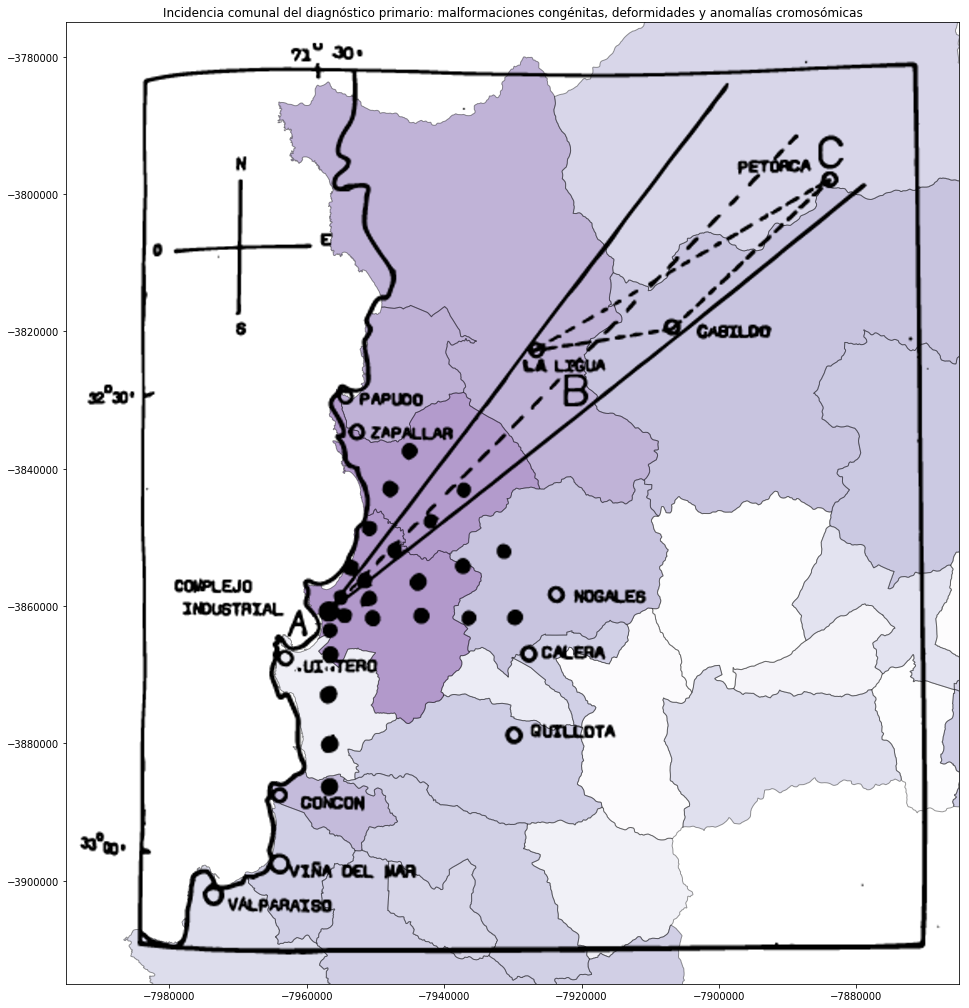

In [12]:
import matplotlib.pyplot as plt


ax = geo_incidencia.plot(column='Taza comuna', figsize=(16,20), alpha=0.4, edgecolor='k', cmap='Purples')
#add_basemap(ax, zoom=10)
plt.title("Incidencia comunal del diagnóstico primario: malformaciones congénitas, deformidades y anomalías cromosómicas")

modelo_pluma = plt.imread('assets/figura.png')
xmin, xmax, ymin, ymax = ax.axis()
ax.imshow(modelo_pluma, extent=[xmin, xmax, ymin, ymax], interpolation='spline16', zorder=1)
ax.axis((-7995000, -7865000, -3915000, -3775000))
# moved to LaTeX
#ax.annotate("Figura 3", (0,0), xycoords='axes fraction', xytext=(.5, -.05), textcoords='axes fraction', fontsize=16)

plt.savefig('assets/mapa-pluma.png', bbox_inches='tight')

### Diferentes zonas de interés
Debido a que el mapa y la incidencia de Q00-Q99 parecieran indicar en la dirección opuesta de la ciudad de Quintero, y la sospecha de que Concón tenga su propia fuente de contaminación (Refinería de petróleo ENAP), analizamos tres grupos en paralelo: El primero excluyendo Concón y Quintero, el segundo incluyendo ambas comunas, y el tercero incluyendo Concón y excluyendo Quintero. 

A continuación, graficamos la incidencia del diagnóstico primario en estos grupos e imprimimos algunos indicadores de representatividad como tamaño del grupo, y cuántos de sus diagnósticos primarios están entre los 10 principales que graficamos.

Zona de interés: Puchuncaví, Zapallar, Papudo, La Ligua, Petorca, Cabildo, Nogales
Total defunciones en el grupo de interés: 313
Total defunciones en los 10 principales diagnósticos primarios del grupo de interés: 308
Fracción del total: 0.984


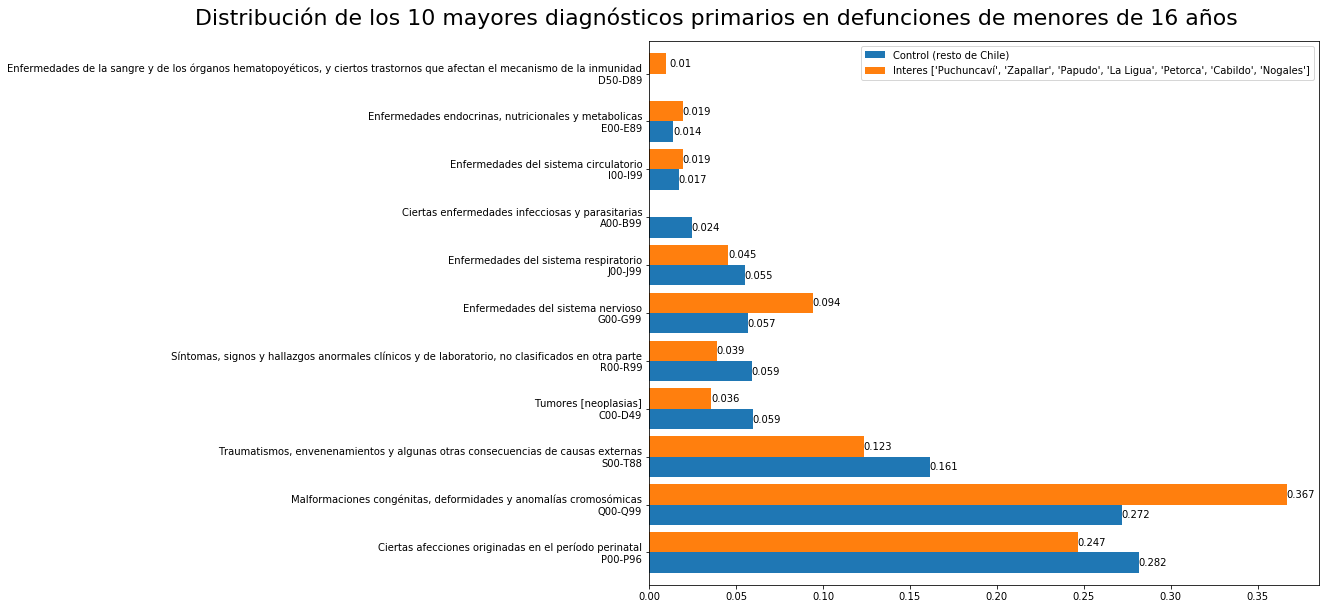

Zona de interés: Puchuncaví, Zapallar, Papudo, La Ligua, Petorca, Cabildo, Nogales, Concón, Quintero
Total defunciones en el grupo de interés: 471
Total defunciones en los 10 principales diagnósticos primarios del grupo de interés: 462
Fracción del total: 0.981


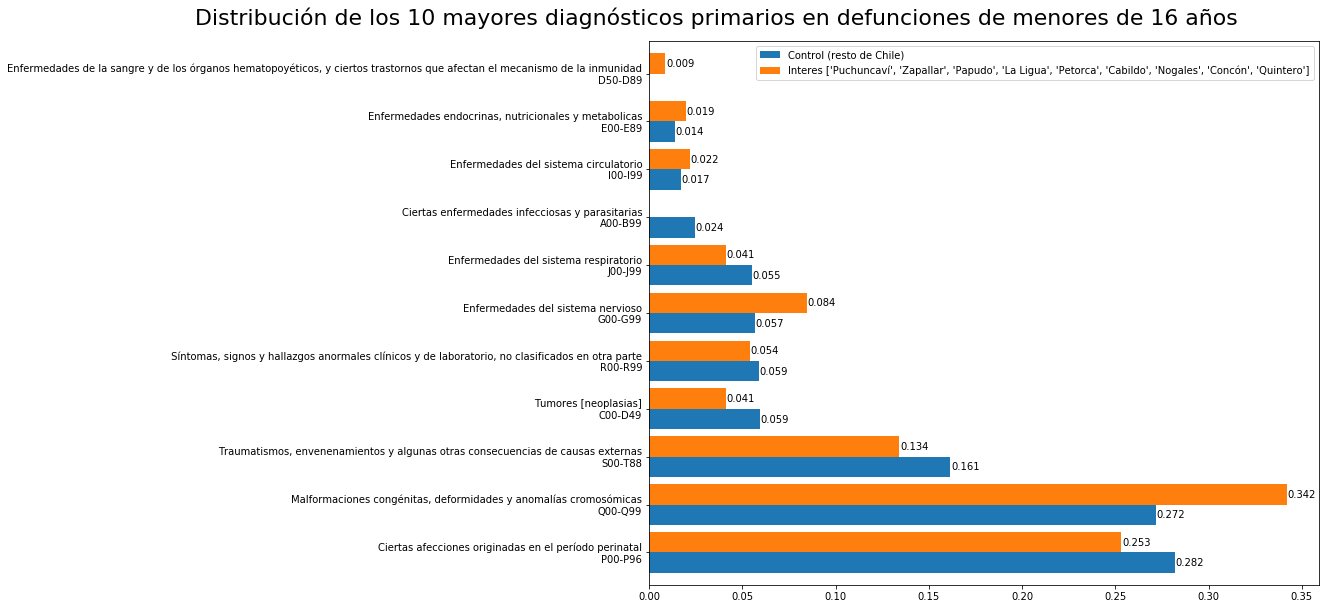

Zona de interés: Puchuncaví, Zapallar, Papudo, La Ligua, Petorca, Cabildo, Nogales, Concón
Total defunciones en el grupo de interés: 398
Total defunciones en los 10 principales diagnósticos primarios del grupo de interés: 390
Fracción del total: 0.980


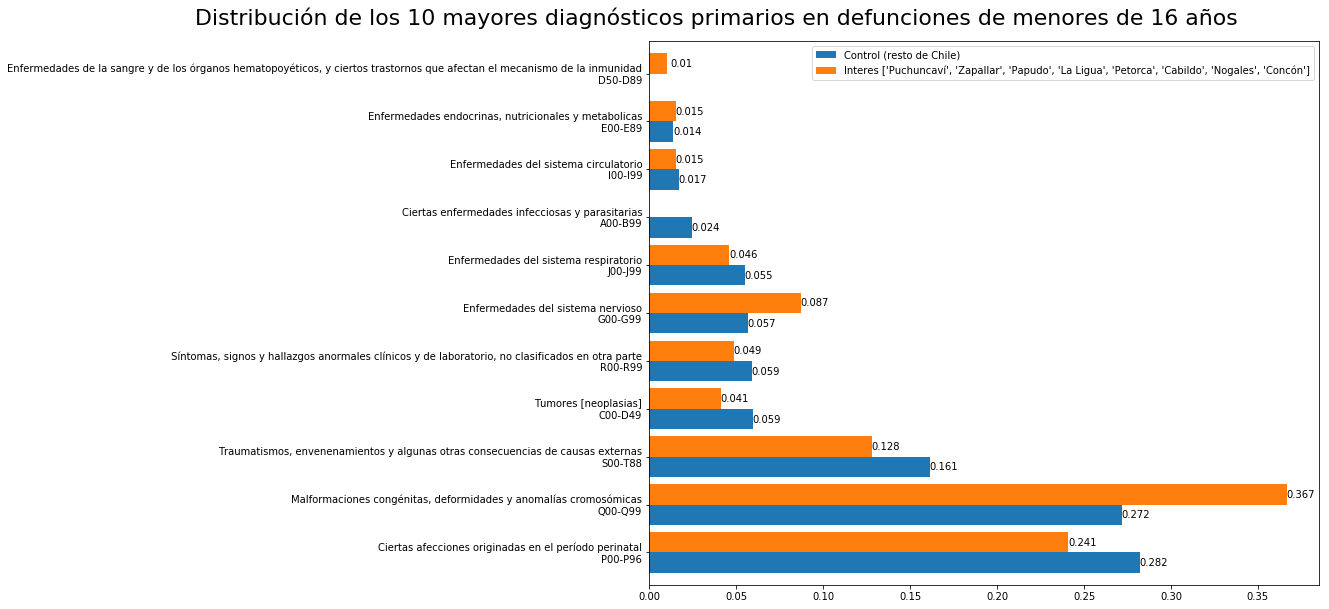

In [13]:
graficos = [
    ('Figura 4', ["Puchuncaví", 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales']),
    ('Figura 5', ["Puchuncaví", 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales', 'Concón', 'Quintero']),
    ('Figura 6', ["Puchuncaví", 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales', 'Concón'])
]
for fig_name, comunas_interes in graficos:
    compare_primary_diagnosis(poblacion, comunas_interes, footer = fig_name)

## Observaciones
Al comparar estos gráficos, inmediatamente notamos que el diagnóstico primario _Malformaciones congénitas, deformidades y anomalías cromosómicas_ (CIE-10: Q00-Q99), es considerablemente más alto en los grupos de interés que en el resto del país como grupo de control (36.7%, 34.2% y 36.7% por sobre 27.2%).

## Validación
Para validar estas observaciones realizamos una prueba de permutación:

Por cada grupo, tomamos un millón de muestras al azar del mismo tamaño que el grupo de interés (308, 471 y 398) desde el grupo de control, y observaremos la distribución del diagnóstico primario de interés en estas muestras,  en contraste con casos seleccionados por zona geográfica de interés, a fin de responder:

__¿Qué tan probable es observar las incidencias (36.7%, 34.2% y 36.7%) que se dan en nuestros grupos de interés en cualquier otro grupo del mismo tamaño muestreado al azar desde el grupo de control??__

In [ ]:
# Corremos las simulaciones (en otra maquina)
from tqdm.auto import tqdm

def simulate_resampling(poblacion, comunas_interes, name, n_simulaciones = 100, top_n = 10):
    # Creamos grupos
    defunciones_test = poblacion.query('comune in @comunas_interes') # Menores en zona de interes
    defunciones_control = poblacion.query('comune not in @comunas_interes') # Menores resto de Chile (control)
    
    sample_size = defunciones_test.shape[0]
    
    # Imprimimos información general
    print('Zona de interés: {}'.format(comunas_interes))
    print('Tamaño de muestra: {}'.format(sample_size))
    
    simulaciones = []
    for i in tqdm(range(n_simulaciones), unit='muestras'):
        sample = defunciones_control.sample(n=sample_size).primary_code_0.value_counts()[:top_n]
        simulaciones.append(sample['Q00-Q99']/sample.sum()) # Malformaciones congénitas, deformidades y anomalías cromosómicas
    
    simulaciones = pd.DataFrame(simulaciones, columns=['fraccion'])
    simulaciones.to_feather('simulaciones-{}-{}.feather'.format(n_simulaciones, name))

for group_id, (_, comunas) in enumerate(graficos):
    name = 'grupo_{}'.format(group_id)
    simulate_resampling(poblacion, comunas, name)
    print(group_id)
    #print(comunas)

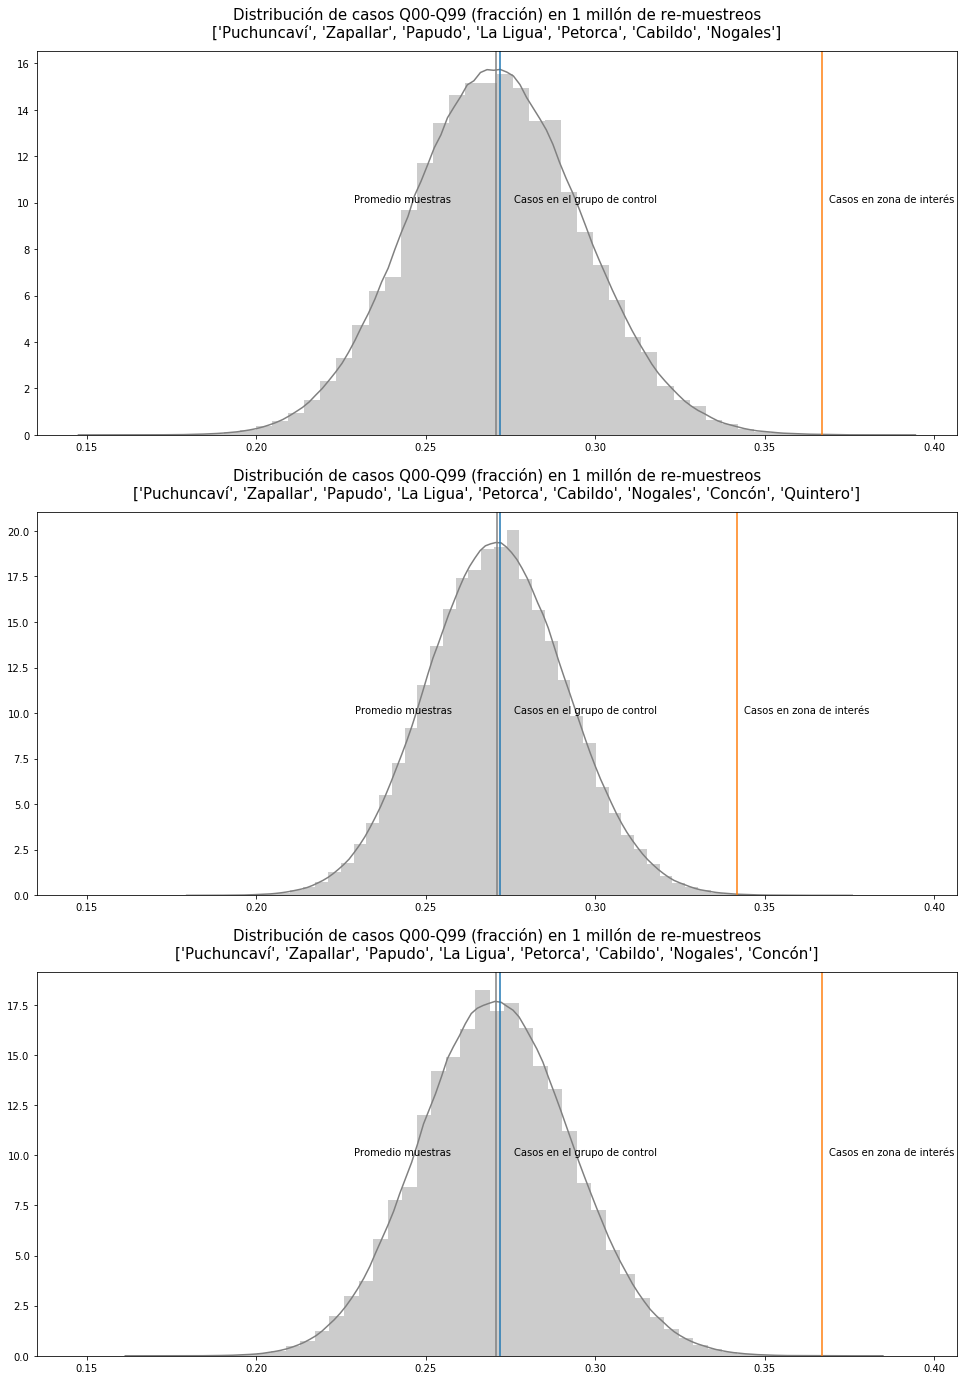

In [14]:
import seaborn as sns

incidencias = [.367, .342, .367]
descr_grupos = ['Sin Quintero ni Concón', 'Incluyendo Quintero y Concón', 'Incluyendo sólo Concón']

#fig, ax = plt.subplots()
fig = plt.figure(figsize=(16.5, 8 * 3))
ax = None

for group_id, (_, comunas) in enumerate(graficos):
    name = 'grupo_{}'.format(group_id)
    filename = 'simulaciones-1000000-{}.feather'.format(name)
    simulaciones = pd.read_feather(filename)
    title = 'Distribución de casos Q00-Q99 (fracción) en 1 millón de re-muestreos\n{}'.format(comunas)

    ax = fig.add_subplot(int('31{}'.format(group_id + 1)), sharex=ax)
    ax = sns.distplot(simulaciones.fraccion.values, color='grey', bins=50, ax=ax)
    ax.set_title(title, size=15, y=1.02)
    ax.axvline(incidencias[group_id], label="", color='tab:orange')
    ax.text(incidencias[group_id] + .002, 10,'Casos en zona de interés')
    ax.axvline(.272, label="")
    ax.text(.276,10,'Casos en el grupo de control')
    ax.axvline(simulaciones.fraccion.mean(), label="", color='grey')
    ax.text(simulaciones.fraccion.mean()-.042, 10,'Promedio muestras')
    
# Moved to LaTeX
#ax.annotate("Figura 7", (0,0), xycoords='axes fraction', xytext=(.45, -.1), textcoords='axes fraction', fontsize=16)
fig.savefig('assets/distribucion.png', bbox_inches='tight')

## Otros valores de interés
El gráfico anterior, muestra que es extremadamente improbable obtener la incidencia del diagnostico primario de interés (malformaciones congénitas, deformidades y anomalías cromosómicas), que se observa la zona de interés, desde muestras del mismo tamaño tomadas al azar desde el resto de Chile.

A continuación cuantificamos la observación anterior con los siguientes números:
 - Probabilidad de obtener este resultado o más al azar (P-Value)
 - Incidencia promedio en muestras al azar desde el grupo de control
 - Desviación standard de muestras al azar desde el grupo de control
 - Cuantificación en desviaciones standards de cuanto se aleja la observación de interés desde el promedio de los 10.000 re-muestreos

In [125]:
for group_id, (_, comunas) in enumerate(graficos):
    name = 'grupo_{}'.format(group_id)
    filename = 'simulaciones-1000000-{}.feather'.format(name)
    simulaciones = pd.read_feather(filename)
    title = 'Distribución de casos Q00-Q99 (fracción) en 1 millón de re-muestreos [{}]'.format(descr_grupos[group_id])
    print(comunas)

    # Probabilidad de obtener este resultado o más al azar (P-Value)
    incidencia = incidencias[group_id]
    pvalue = simulaciones.query('fraccion > @incidencia').shape[0] / simulaciones.shape[0]
    print('P-value: {:.5f}'.format(pvalue))

    # Promedio de muestras
    promedio_muestras = simulaciones.fraccion.mean()
    print('Promedio de las muestras: {:.5f}'.format(promedio_muestras))

    # Desviación standar
    std = simulaciones.fraccion.std()
    print('Desviación standard de las muestras: {:.5f}'.format(std))

    # ¿cuantas desviaciones standards se aleja?
    std_delta = (.348 - simulaciones.fraccion.mean()) / simulaciones.fraccion.std()
    print('Distancia entre el promedio de las muestras y el grupo de interés en desviaciones standard: {:.2f}\n'.format(std_delta))

['Puchuncaví', 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales']
P-value: 0.00010
Promedio de las muestras: 0.27083
Desviación standard de las muestras: 0.02528
Distancia entre el promedio de las muestras y el grupo de interés en desviaciones standard: 3.05

['Puchuncaví', 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales', 'Concón', 'Quintero']
P-value: 0.00039
Promedio de las muestras: 0.27103
Desviación standard de las muestras: 0.02059
Distancia entre el promedio de las muestras y el grupo de interés en desviaciones standard: 3.74

['Puchuncaví', 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales', 'Concón']
P-value: 0.00002
Promedio de las muestras: 0.27085
Desviación standard de las muestras: 0.02239
Distancia entre el promedio de las muestras y el grupo de interés en desviaciones standard: 3.45



## Variaciones en el P-value
A razón de haber observado variaciones en el primer dígito no-cero del p-value durante las primeras ejecuciones de 10.000 re-muestreos, se aumento la cantidad de re-muestreos en dos órdenes de magnitud (a un millón). Y para entender como se comporta este P-value respecto a la cantidad de re-muestreos, tomamos sub-muestras del millón de muestras, incrementando su tamaño iterativamente en 500 re-muestreos. Al graficar el p-value en estos distintos tamaños de re-muestreos, se observa que en el n inicial de 10.000 el p-value se lograba estabilizar en su orden de magnitud, pero con un millón se estabilizaba considerablemente más.

In [16]:
p_values = {}


for group_id, (_, comunas) in enumerate(graficos):
    name = 'grupo_{}'.format(group_id)
    filename = 'simulaciones-1000000-{}.feather'.format(name)
    simulaciones = pd.read_feather(filename)
    n_simulaciones = simulaciones.shape[0]
    
    incidencia = incidencias[group_id]
    p_values[group_id] = pd.DataFrame()
    step = 500
    for n_samples in range(step, n_simulaciones, step):
        current_sample_set = simulaciones.sample(n=n_samples)
        pvalue = current_sample_set.query('fraccion > @incidencia').shape[0] / current_sample_set.shape[0]
        data = {
            'N resamples': current_sample_set.shape[0],
            'P-value': pvalue
        }
        p_values[group_id] = p_values[group_id].append(data, ignore_index=True)

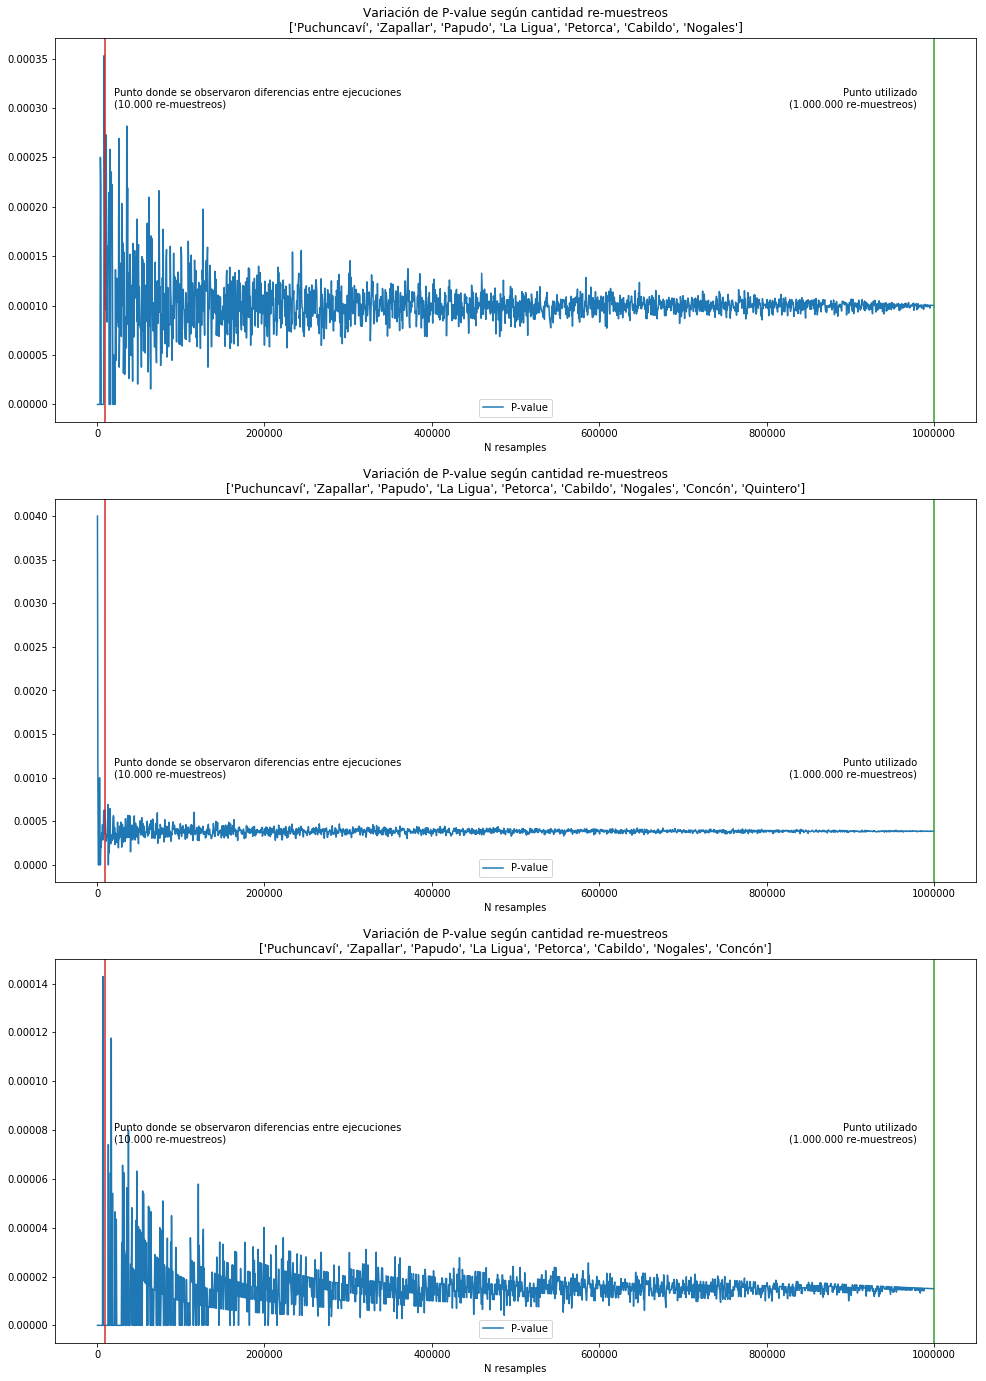

In [17]:
label_y = [.0003, .001, .000075]

fig = plt.figure(figsize=(16.5, 8 * 3))
for group_id, (_, comunas) in enumerate(graficos):
    ax = fig.add_subplot(int('31{}'.format(group_id + 1)), sharex=ax)
    
    sns.lineplot(data = p_values[group_id].set_index('N resamples'), ax=ax)
    
    ax.set_title('Variación de P-value según cantidad re-muestreos\n{}'.format(comunas))
    
    # Anotamos
    ax.axvline(10000, label="", color='tab:red')
    ax.text(20000, label_y[group_id],'Punto donde se observaron diferencias entre ejecuciones\n(10.000 re-muestreos)')

    ax.axvline(1000000, label="", color='tab:green')
    ax.text(980000, label_y[group_id],'Punto utilizado\n(1.000.000 re-muestreos)', horizontalalignment='right')
    
# Moved to LaTeX
#plt.annotate("Figura 8", (0,0), xycoords='axes fraction', xytext=(.45, -.15), textcoords='axes fraction', fontsize=16)
foo = fig.savefig('assets/variacion-p-values.png', bbox_inches='tight')

## Conclusiones


Grupo | Distancia DS | P-Value | Comunas
--|--|--|--
0 |         3.05 | 0.00010| ['Puchuncaví', 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales']
1 |         3.74 | 0.00039 | ['Puchuncaví', 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales', 'Concón', 'Quintero']
2 |         3.45 | 0.00002 | ['Puchuncaví', 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales', 'Concón']


Tales distancias (3.05, 3.74 y 3.45 desviaciones estándar) entre los valores observados y los promedios del grupo de control (figura 7), así como los p-values observados en el millón de re-muestreos por grupo y su estabilidad observada (figura 8), muestran __una cifra de mortalidad anómala en la zona en estudio__.

Si le restamos la incidencia nacional esperada _(0.272  * 313, 0.272 * 471, 0.272 * 398)_ a los grupos de análisis _(0.367  * 313, 0.342 * 471, 0.367 * 398)_ podremos estimar que __estamos observando 29.73, 32.97 o 37.8 muertes de menores hasta 16 años en las zonas analizadas, que no observaríamos en el resto de Chile a igual tamaño de muestra__, en el periodo 1998-2016. 

Se recomienda enfáticamente seguir observando estos números mientras la fuente de contaminación siga ahí, y durante dos a tres décadas después de que el complejo industrial sea clausurado y la zona, descontaminada.

Se invita a los expertos de las áreas relevantes (salud, bioquímica, ecología, etc.) a investigar la rutas específicas que llevarían al incremento de las defunciones bajo este diagnóstico primario. Se invita, además, a los gobernantes a hacer la prueba de campo, clausurando las fuentes y descontaminando el área, para observar, en algunas décadas, la evolución de la incidencia de este diagnóstico primario en las defunciones de la zona.

### Potencial futuro de la metodología
Esta técnica puede ser escalada a nivel nacional para buscar otros fenómenos del mismo tipo, sin especificar una zona en particular, lo que podría revelar problemas de salud pública fuera del "radar" de los investigadores. Para esto se requeriría construir un graph con comunas como nodos, y sus colindacias geográficas como vértices (tal vez con [los vectores de comunas de la biblioteca del congreso](https://www.bcn.cl/siit/mapas_vectoriales/index_html)), e iterar sobre grupos de comunas colindantes con un mínimo de registros totales. De realizarse, se sugiere nombrar _Perico_ a tal algoritmo que _treparía por Chile_.

### Agradecimientos
 - A mi padre —Dr. Yuri Carvajal— por la orientación bibliográfica, corrección e implementación de LaTeX.
 - A la biblioteca Gabriela Mistral de Ñuñoa por haber sido mi "universidad anfitriona" durante los meses de esta investigación.